# coNNect: Friend Recommendation with GNNs
*Created by Horváth Szilárd (MZ7VX5) and Szarvas Dániel (A85UKT)*

## Overview
This is our solution for our selected homework topic for the BME-VIK MSc "**Deep Learning**" course (Mélytanulás, BMEVITMMA19), which is named "**Friend recommendation with graph neural networks**".

Our task was to build a friend recommendation system based on graph neural networks (GNNs). We had the opportunity to work with anonymized data coming from major social media platforms like Facebook, Google+ and Twitter (now X), that offered us the option to utilize complex user profiles and connection circles.

In [ ]:
import torch
print(torch.__version__)

2.4.1+cu121


In [ ]:
!pip install -q torch_geometric

## Download the data
Our primary data source is SNAP from Stanford (https://snap.stanford.edu/).

- Facebook (10 friend networks): https://snap.stanford.edu/data/ego-Facebook.html
- Google+ (123 friend networks): https://snap.stanford.edu/data/ego-Gplus.html
- Twitter (973 friend networks): https://snap.stanford.edu/data/ego-Twitter.html

In [ ]:
def download_data(social_media: str):
  social_media = social_media.lower()
  social_media_options = ["facebook", "gplus", "twitter"]
  if social_media not in social_media_options:
    raise ValueError(f"Invalid social media name. Select from {social_media_options}.")

  !wget https://snap.stanford.edu/data/{social_media}_combined.txt.gz -P data/{social_media}
  !gunzip data/{social_media}/{social_media}_combined.txt.gz -f
  !wget https://snap.stanford.edu/data/{social_media}.tar.gz -P data/{social_media}
  !tar -xzvf data/{social_media}/{social_media}.tar.gz -C data/{social_media}
  !rm data/{social_media}/{social_media}.tar.gz
  !wget https://snap.stanford.edu/data/readme-Ego.txt -P data/{social_media}

In [ ]:
SOCIAL_MEDIA = "facebook"

download_data(SOCIAL_MEDIA)

--2024-10-13 16:44:46--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘data/facebook/facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K  --.-KB/s    in 0.1s    

2024-10-13 16:44:46 (1.92 MB/s) - ‘data/facebook/facebook_combined.txt.gz’ saved [218576/218576]

--2024-10-13 16:44:47--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘data/facebook/facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K  2.99MB/s    in 0.2s    

2024-10-13 16:

In [ ]:
SOCIAL_MEDIA = "gplus"

download_data(SOCIAL_MEDIA)

--2024-10-13 16:44:48--  https://snap.stanford.edu/data/gplus_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 398930514 (380M) [application/x-gzip]
Saving to: ‘data/gplus/gplus_combined.txt.gz’

gplus_combined.txt. 100%[===================>] 380.45M  22.3MB/s    in 23s     

2024-10-13 16:45:11 (16.3 MB/s) - ‘data/gplus/gplus_combined.txt.gz’ saved [398930514/398930514]

--2024-10-13 16:45:29--  https://snap.stanford.edu/data/gplus.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412610217 (393M) [application/x-gzip]
Saving to: ‘data/gplus/gplus.tar.gz’

gplus.tar.gz        100%[===================>] 393.50M  45.8MB/s    in 9.6s    

2024-10-13 16:45:38 (41.0 

## Load dataset

All of the datasets include connection "circles", ego networks (friend network of a single user), node features (user profiles). The edges are undirected for Facebook, while they are directed for Google+ and Twitter.

We are going to load and analyze only the "Facebook" dataset this time, because the other two datasets are structured the same. We may go on to use them later in the network development process, and since they are structured similarly we can use the same analysis and transformation processes for them as well.

We can make sense of the given file structures from the `readme-Ego.txt` file, which defines the following 5 different file structures (`nodeId` is replaced by the actual ID of the ego node):

- `nodeId.edges` (**node structure**): The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

- `nodeId.circles` (**node structure**): The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

- `nodeId.feat` (**node features**): The features for each of the nodes that appears in the edge file.

- `nodeId.egofeat` (**node features**): The features for the ego user.

- `nodeId.featnames` (**metadata for features**): The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.

Most of the files are structured similarly between different socal media datasets, the only one that is different is featnames.

First, to illustrate the data, we dive into the files. There are 10 friend networks, and we will be looking into number 0.

### `nodeId.edges` (**node structure**):




In [ ]:
!head data/facebook/facebook/0.edges

236 186
122 285
24 346
271 304
176 9
130 329
204 213
252 332
82 65
276 26


We can see the edges in the friend network between nodes. The two numbers in each row are the IDs of two connected nodes.

### `nodeId.circles` (**node structure**):

In [ ]:
!head data/facebook/facebook/0.circles

circle0	71	215	54	61	298	229	81	253	193	97	264	29	132	110	163	259	183	334	245	222
circle1	173
circle2	155	99	327	140	116	147	144	150	270
circle3	51	83	237
circle4	125	344	295	257	55	122	223	59	268	280	84	156	258	236	250	239	69
circle5	23
circle6	337	289	93	17	111	52	137	343	192	35	326	310	214	32	115	321	209	312	41	20
circle7	225	46
circle8	282
circle9	336	204	74	206	292	146	154	164	279	73


In this file, every line is a node ID series that constitutes to a circle, so these are the first circles of the number 0 friend network. All of the circles are listed in this file which are actually not that much in this instance.

### `nodeId.featnames` (**metadata for features**):

For Facebook

In [ ]:
!head -n 15 data/facebook/facebook/0.featnames
!echo -e "\nNumber of features:"
!wc -l data/facebook/facebook/0.featnames

0 birthday;anonymized feature 0
1 birthday;anonymized feature 1
2 birthday;anonymized feature 2
3 birthday;anonymized feature 3
4 birthday;anonymized feature 4
5 birthday;anonymized feature 5
6 birthday;anonymized feature 6
7 birthday;anonymized feature 7
8 education;classes;id;anonymized feature 8
9 education;classes;id;anonymized feature 9
10 education;classes;id;anonymized feature 10
11 education;classes;id;anonymized feature 11
12 education;classes;id;anonymized feature 12
13 education;concentration;id;anonymized feature 13
14 education;concentration;id;anonymized feature 14

Number of features:
224 data/facebook/facebook/0.featnames


In [ ]:
!head -n 15 data/facebook/facebook/107.featnames
!echo -e "\nNumber of features:"
!wc -l data/facebook/facebook/107.featnames

0 birthday;anonymized feature 376
1 birthday;anonymized feature 0
2 birthday;anonymized feature 1
3 birthday;anonymized feature 209
4 birthday;anonymized feature 2
5 birthday;anonymized feature 3
6 birthday;anonymized feature 210
7 birthday;anonymized feature 4
8 birthday;anonymized feature 5
9 birthday;anonymized feature 6
10 birthday;anonymized feature 7
11 birthday;anonymized feature 377
12 birthday;anonymized feature 378
13 birthday;anonymized feature 379
14 birthday;anonymized feature 380

Number of features:
576 data/facebook/facebook/107.featnames


The main problem with the facebook dataset is visible here. Between the files the number of features is different. The features are already on-hot encoded and anonymized, so we couldn't really combine together the different files. The number of encoding for the same varibale (eg. birthday) differs between diffent files, so the encodings could have happened differently for each.

For google+

In [ ]:
!head -n 15 data/gplus/gplus/100466178325794757407.featnames
!echo -e "\nNumber of features:"
!wc -l data/gplus/gplus/100466178325794757407.featnames

0 gender:1
1 gender:2
2 gender:3
3 institution:
4 institution:Android and Me
5 institution:Crazy John's
6 institution:Google
7 institution:Microsoft
8 institution:Mobicartel
9 institution:Royal Bank of Canada
10 institution:University of Waikato
11 job_title:&
12 job_title:/
13 job_title:@
14 job_title:a

Number of features:
151 data/gplus/gplus/100466178325794757407.featnames


In google's case the same thing applies that the number of features are different for each files, however google's data is bigger, so even one file's worth of data could be enought. And in case of google the feature names are not anonymized, however there are a lot of bad feature values(eg. job_title:a) and some of the files are very hard to read because they contain all kinds of symbols that need to be handled separatly.

### `nodeId.feat` (**node features**):

In [ ]:
!head data/facebook/facebook/0.feat
!echo -e "\nNumbers in a line (a.k.a. number of features):"
!head -n 1 data/facebook/facebook/0.feat | tr -cd ' \t' | wc -c

1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

It can be seen that for each node we get a 224-length vector, where the first column represents the node's row number, while the remaining 223-length binary vector represents the value of each of the 223 features. This is already a one-hot feature vector, since only 0 and 1 are included.

### `nodeId.egofeat` (**node features**):

In [ ]:
!head data/facebook/facebook/0.egofeat
!echo -e "\nNumbers in a line (a.k.a. number of features):"
!head -n 1 data/facebook/facebook/0.egofeat | tr -cd ' \t' | wc -c

0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0

Numbers in a line (a.k.a. number of features):
223


You can see the 223 features in the same way, only here for the ego node. The reason why the number 224 is no longer present is that while in the `0.feat` file the first column was a line numbering, here it was not needed because of the single line and has been omitted.

# Facebook imported dataset

### Working with the dataset

Since this dataset is quite unique and specific with the ego networks and it's circles, we wouldn't want to create errors in our final solution because of parsing errors. We examined the data ourselves, but used a solution for parsing that's certainly devoid of mistakes.

This is the reason we decided to parse and download our solution with the help of `pytorch_geometric` itself, using a data class from `torch_geometric.datasets` named `SNAPDataset` (package code is visible on [this link](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/snap_dataset.html)).

We went with it because we go by the philosophy that if there is something already done and working correctly, furthermore we could't write it better, then we, as engineers, should utilize it.

In [ ]:
from torch_geometric.datasets import SNAPDataset

facebook_dataset = SNAPDataset(root=".", name="ego-facebook")

Processing...
100%|██████████| 10/10 [00:00<00:00, 16.44it/s]
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([EgoData])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


There are 10 different datasets in this. From analyzing the direct source we downloaded from their website, what we think they did is just to combine all of the data into one and keep all the columns as well. We haven't found any information abut it. Also the column names are unkown.

In [ ]:
for i in range(len(facebook_dataset)):
  print(facebook_dataset[i])

EgoData(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325])
EgoData(x=[1045, 1406], edge_index=[2, 55510], circle=[501], circle_batch=[501])
EgoData(x=[792, 1406], edge_index=[2, 29618], circle=[777], circle_batch=[777])
EgoData(x=[755, 1406], edge_index=[2, 61484], circle=[1065], circle_batch=[1065])
EgoData(x=[547, 1406], edge_index=[2, 10696], circle=[192], circle_batch=[192])
EgoData(x=[227, 1406], edge_index=[2, 6830], circle=[567], circle_batch=[567])
EgoData(x=[59, 1406], edge_index=[2, 392], circle=[58], circle_batch=[58])
EgoData(x=[159, 1406], edge_index=[2, 3670], circle=[178], circle_batch=[178])
EgoData(x=[170, 1406], edge_index=[2, 3594], circle=[485], circle_batch=[485])
EgoData(x=[66, 1406], edge_index=[2, 612], circle=[85], circle_batch=[85])


In [ ]:
import torch
from torch_geometric.data import Data

edge_index_offset = 0
combined_edge_index = None
combined_x = None

for i in range(len(facebook_dataset)):
  data = facebook_dataset[i]
  # Shift node indices in edge_index
  shifted_edge_index = data.edge_index + edge_index_offset

  if combined_edge_index is None:
    combined_edge_index = shifted_edge_index
  else:
    combined_edge_index = torch.cat([combined_edge_index, shifted_edge_index], dim=1)

  if combined_x is None:
    combined_x = data.x
  else:
    combined_x = torch.cat([combined_x, data.x], dim=0)

  edge_index_offset += data.num_nodes

facebook_combined_geo_data = Data(x=combined_x, edge_index=combined_edge_index)

### Train-test split of geo data

The way it works is it splits the edges into train, val, test splits. The nodes stay the same, we chose this, because it is a edge prediction task. For the validation and test splits it also adds false edges, to check for false positive predictions.

It makes 3 Data objects. x will be the same for all of them. The edges are contained in the edge_label_index variable and edge_label contains if they are true or false edges in case of val and test datasets

In [ ]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(is_undirected=True,
                            num_val=0.1,
                            num_test=0.2)
geo_train, geo_val, geo_test = transform(facebook_combined_geo_data)

In [ ]:
tab_fb_data = facebook_combined_geo_data.x

tab_fb_data = tab_fb_data.to(dtype=torch.int64)

indices = torch.arange(tab_fb_data.shape[0], dtype=torch.int64).unsqueeze(1)
indexed_tensor = torch.cat([indices, tab_fb_data], dim=1)
fb_df_tab = pd.DataFrame(indexed_tensor)

In [ ]:
fb_df_tab

,0,1,2,3,4,5,6,7,8,9,...,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4162,4162,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4163,4163,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4164,4164,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4165,4165,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ones_count = (fb_df_tab == 1).sum().sum()

print(f"Total number of 1s in the DataFrame: {ones_count}")

Total number of 1s in the DataFrame: 39368


There are only a few number of 1s in the dataframe, this is probably due to them combining all the files and columns, but again they didn't give info about it.

### Creating tabular dataset for baseline
We only used a fraction of the data for now, because of ram limits and testing, for the training we will increase this.

In [ ]:
import itertools


all_node_pairs_fb = pd.DataFrame(list(itertools.product(fb_df_tab[0], fb_df_tab[0])), columns=['node1', 'node2'])

sampled_node_pairs_fb = all_node_pairs_fb.sample(n=10000, random_state=42)

edge_set = set(zip(facebook_combined_geo_data.edge_index[0].tolist(), facebook_combined_geo_data.edge_index[1].tolist()))


def are_connected(row, edge_index):
  node1 = int(row['node1'])
  node2 = int(row['node2'])
  edge_exists = (node1, node2) in edge_set or (node2, node1) in edge_set
  if edge_exists:
    return 1
  else:
    return 0


sampled_node_pairs_fb['connected'] = sampled_node_pairs_fb.apply(lambda row: are_connected(row, edge_set), axis=1).astype(int)
print(sampled_node_pairs_fb['connected'].value_counts())


node1_info = fb_df_tab.rename(columns={0: 'node1'})
node2_info = fb_df_tab.rename(columns={0: 'node2'})

sampled_node_pairs_fb = sampled_node_pairs_fb.merge(node1_info, left_on='node1', right_on='node1', how='left', suffixes=('', '_node1'))

sampled_node_pairs_fb = sampled_node_pairs_fb.merge(node2_info, left_on='node2', right_on='node2', how='left', suffixes=('', '_node2'))

print(sampled_node_pairs_fb)

connected
0    9901
1      99
Name: count, dtype: int64
      node1  node2  connected  1  2  3  4  5  6  7  ...  1397_node2  \
0      3899   1572          0  0  0  0  0  0  0  0  ...           0   
1       118   2704          0  0  0  0  0  0  0  0  ...           0   
2      2253   1334          0  0  0  0  0  0  0  0  ...           0   
3      2147   3714          0  0  0  0  0  0  0  0  ...           0   
4      3232   4025          0  0  0  0  0  0  0  0  ...           0   
...     ...    ...        ... .. .. .. .. .. .. ..  ...         ...   
9995   4135   1864          0  0  0  0  0  0  0  0  ...           0   
9996   1224    516          0  0  0  0  0  0  0  0  ...           0   
9997   2463    681          0  0  0  0  0  0  0  0  ...           0   
9998   3572   2605          0  0  0  0  0  0  0  0  ...           0   
9999    229   1589          0  0  0  0  0  0  0  0  ...           0   

      1398_node2  1399_node2  1400_node2  1401_node2  1402_node2  1403_node2  \
0          

### Train test split of tabular data

In [ ]:
from sklearn.model_selection import train_test_split


train_pairs_fb, test_pairs_fb = train_test_split(sampled_node_pairs_fb, test_size=0.2, random_state=42)
train_pairs_fb, val_pairs_fb = train_test_split(train_pairs_fb, test_size=0.15, random_state=42)


print(f"Train set size: {train_pairs_fb.shape}")
print(f"Validation set size: {val_pairs_fb.shape}")
print(f"Test set size: {test_pairs_fb.shape}")

Train set size: (6800, 2815)
Validation set size: (1200, 2815)
Test set size: (2000, 2815)


## Analyze dataset

We already conducted static analysis a few cells back when we looked into the files themselves. However, we want more than just that. Analyzing larger graphs is a near impossible task when we are only using adjacency matrices to do it. We need to visualize it, to make some kind of analysis.

It's can also be challenging to visualize a huge graph dataset like the ones we are working with. Finding the right package and data format to visualize the graphs isn't trivial. We chose `pyvis` in our case.

In [ ]:
!pip install pyvis -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pyvis.network import Network

We use the combined .txt file that consists of all the existing connections inside the graph. This enables us to analyze the data without the need to use other complex data structures.

In [ ]:
connection_df = pd.read_csv(f"/content/data/{SOCIAL_MEDIA}/{SOCIAL_MEDIA}_combined.txt", delimiter=" ")
len(connection_df)

88233

We see that the full network consists of 88.233 number of connections between nodes: these are the number of friendships in this dataset.

In [ ]:
connection_df = connection_df.rename(columns={"0": "person_A", "1": "person_B"})
connection_df.head()

,person_A,person_B
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [ ]:
net = Network(
    notebook = True,
    cdn_resources = "remote",
    bgcolor = "#111111",
    font_color = "white",
    height = "780px",
    width = "100%",
    select_menu = True,
    filter_menu = True,
)

Since plotting 88.233 nodes in a notebook wouldn't work, we sampled only a few hundred nodes to plot and constructed the visualization from them.

In [ ]:
from IPython.core.display import HTML

sample = connection_df.sample(n=500)
nodes = list(set([*sample["person_A"], *sample["person_B"]]))
edges = sample.values.tolist()
net.add_nodes(nodes)
net.add_edges(edges)
net.show("graph.html", notebook=True)
display(HTML('graph.html'))

graph.html


With this interactive plot we can see that if we select one of the ego nodes (specific number from the name of the files, e.g. 0 or 107), there is a section that is more dense in connections, centered around the selected ego node.

#### Neighbour distribution
Than we checked the neighbour distribution

In [ ]:
from collections import Counter

unique_nodes_fb, node_counts_fb = zip(*Counter(facebook_combined_geo_data.edge_index.flatten().tolist()).items())
neigh_df_fb = pd.DataFrame({'Node_Index': unique_nodes_fb, 'Neighbor_Count': node_counts_fb})

all_nodes_fb = list(range(facebook_combined_geo_data.x.shape[0]))

nodes_without_neighbors_fb = list(set(all_nodes_fb) - set(unique_nodes_fb))

neigh_df_fb = pd.concat([neigh_df_fb, pd.DataFrame({'Node_Index': nodes_without_neighbors_fb, 'Neighbor_Count': 0})])

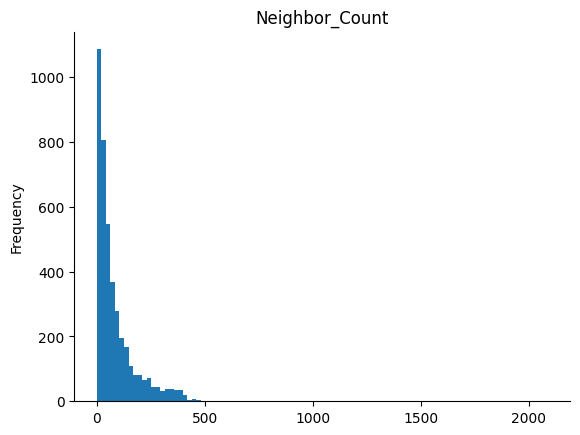

In [ ]:
from matplotlib import pyplot as plt
neigh_df_fb['Neighbor_Count'].plot(kind='hist', bins=100, title='Neighbor_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
mean_neighbor_count = neigh_df_fb['Neighbor_Count'].mean()
std_neighbor_count = neigh_df_fb['Neighbor_Count'].std()
min_neighbor_count = neigh_df_fb['Neighbor_Count'].min()
max_neighbor_count = neigh_df_fb['Neighbor_Count'].max()


print(f"Mean Neighbor Count: {mean_neighbor_count}")
print(f"Standard Deviation of Neighbor Count: {std_neighbor_count}")
print(f"Minimum Neighbor Count: {min_neighbor_count}")
print(f"Maximum Neighbor Count: {max_neighbor_count}")

Mean Neighbor Count: 85.49268058555316
Standard Deviation of Neighbor Count: 103.19496614945933
Minimum Neighbor Count: 2
Maximum Neighbor Count: 2088


There were no nodes that don't have neighbours. Most of the nodes only have a few neighbours, the frequency of a given neighbour count decreases as the neighbour count increases

In [ ]:

import pandas as pd
column_ones_count_fb = pd.DataFrame((facebook_combined_geo_data.x == 1).sum(dim=0), columns=['ones_count'])
column_ones_count_fb


,ones_count
0,86
1,74
2,2
3,4
4,3
...,...
1401,7
1402,2
1403,2
1404,2


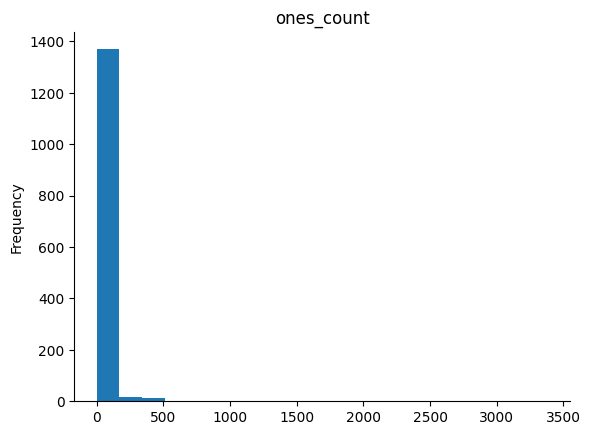

In [ ]:
# @title ones_count

from matplotlib import pyplot as plt
column_ones_count['ones_count'].plot(kind='hist', bins=20, title='ones_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
mean_neighbor_count = column_ones_count_fb['ones_count'].mean()
std_neighbor_count = column_ones_count_fb['ones_count'].std()
min_neighbor_count = column_ones_count_fb['ones_count'].min()
max_neighbor_count = column_ones_count_fb['ones_count'].max()


print(f"Mean 1 Count: {mean_neighbor_count}")
print(f"Standard Deviation of 1 Count: {std_neighbor_count}")
print(f"Minimum 1 Count: {min_neighbor_count}")
print(f"Maximum 1 Count: {max_neighbor_count}")

Mean 1 Count: 27.999288762446657
Standard Deviation of 1 Count: 170.38320009595526
Minimum 1 Count: 1
Maximum 1 Count: 3384


We also checked how many 1s are in each column. All the columns are one-hot encoded variables, so the data is very sparse

# Google+ dataset

## Preparing the data
In the data source we had 3 different social medias to choose data from. However there were several issues with most of them that we couldn't fix without making the data too inconsistent.

With facebook the main problem was that all of the feature data for the nodes(people) were already one hot encoded and anonymized. Data comes in several different files and we wanted to combine them, because facebook data is relatevly small, but the number and name of the features were different for all of them. This meant that we can't combine the data cleanly.

The second choice was google plus data. here files are separated as well, but the column names are more consistent. Here one other problem was that many files are in bad format. So to keep it clean we chose to only use one file worth of data. Or if we combine them, only combine a few, because the column names here have to  be merged again

First we checked how many nodes are in each file so we can choose the bigger ones.

In [ ]:
import os

gplus_dir = 'data/gplus/gplus'
files_in_gplus = os.listdir(gplus_dir)

feat_files = [f for f in files_in_gplus if f.endswith('.feat')]

for filename in feat_files:
  filepath = os.path.join(gplus_dir, filename)
  try:
    df = pd.read_csv(filepath, sep=' ', header=None)
    print(f"File: {filename}, Shape: {df.shape}")
  except Exception as e:
    print(f"Error reading {filename}: {e}")

File: 103241736833663734962.feat, Shape: (138, 130)
File: 118255645714452180374.feat, Shape: (215, 159)
File: 100715738096376666180.feat, Shape: (1209, 1007)
File: 116059998563577101552.feat, Shape: (1389, 754)
File: 108883879052307976051.feat, Shape: (1766, 1306)
File: 101185748996927059931.feat, Shape: (1054, 546)
File: 100518419853963396365.feat, Shape: (334, 265)
File: 100535338638690515335.feat, Shape: (1206, 944)
File: 111213696402662884531.feat, Shape: (260, 138)
File: 107459220492917008623.feat, Shape: (583, 444)
File: 111058843129764709244.feat, Shape: (3601, 2535)


KeyboardInterrupt: 

We read data from two main files. The .feat files contain the nodes' features. The .edges files contain the edges of the graph via node pairs. We also use the .featname files to extract the feature_names for data analysis.

For graph neural nets the needed input is pytorch_geometric Dataset. In this we need the nodes and their features as 'x', the edges are given via node pairs in the edge_index.

In the original the in the .feat files the first column is the index of the node. In pytorch_gemetric datasets x shouldn't contain the index of the node, and in the edge_index the index of the node is where it is in x. So this means we needed to map and transform the edge_index so it contains the indexes of nodes correctly.

In [ ]:
def map_and_replace_indexes(df_feat, df_edges):
  old_indexes = df_feat.iloc[:, 0].tolist()
  new_indexes = list(range(len(old_indexes)))

  index_mapping = dict(zip(old_indexes, new_indexes))

  df_edges.iloc[:, 0] = df_edges.iloc[:, 0].map(index_mapping)
  df_edges.iloc[:, 1] = df_edges.iloc[:, 1].map(index_mapping)

  df_feat.iloc[:, 0] = df_feat.iloc[:, 0].map(index_mapping)

In [ ]:
import os
import pandas as pd
from torch_geometric.data import Data

gplus_dir = 'data/gplus/gplus'
choosen_file = '107489144252174167638'

def load_and_transform_data(filename):
  feat_file = os.path.join(gplus_dir, filename + '.feat')
  featnames_file = os.path.join(gplus_dir, filename + '.featnames')
  edges_file = os.path.join(gplus_dir, filename + '.edges')
  try:
    df_feat = pd.read_csv(feat_file, sep=' ', header=None)
    df_featnames = pd.read_csv(featnames_file, sep=':', header=None, on_bad_lines='skip')
    df_edges = pd.read_csv(edges_file, sep=' ', header=None)


    feature_names = df_featnames[0].tolist()

    #Set column names for df_feat
    #df_feat.columns = ['Id'] + feature_names

    map_and_replace_indexes(df_feat, df_edges)

    df_feat = df_feat.apply(pd.to_numeric, errors='coerce')
    df_edges = df_edges.apply(pd.to_numeric, errors='coerce')

    if df_feat.isnull().values.any():
        print(f"Nan data in feat_file")
        df_feat.fillna(0, inplace=True)

    if df_edges.isnull().values.any():
        print(f"Nan data in edge file")
        df_edges.fillna(0, inplace=True)



    edge_index = torch.tensor(df_edges.values.T, dtype=torch.int)
    x = torch.tensor(df_feat.values, dtype=torch.float)


    data = Data(x=x[:,1:], edge_index=edge_index)


    return data, df_feat

  except Exception as e:
    print(f"Error loading data for {filename}: {e}")
    return None


geo_data, norm_data = load_and_transform_data(choosen_file)


### Data split of the geometric dataset.
 The way it works is it splits the edges into train, val, test splits. The nodes stay the same, we chose this, because it is a edge prediction task. For the validation and test splits it also adds false edges, to check for false positive predictions.

It makes 3 Data objects. x will be the same for all of them. The edges are contained in the edge_label_index variable and edge_label contains if they are true or false edges in case of val and test datasets

In [ ]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(is_undirected=True,
                            num_val=0.1,
                            num_test=0.2)
geo_train, geo_val, geo_test = transform(geo_data)

### Preparing regular Dataset for baseline model
For baseline model we will use a regular neural network or some other kind of variation that uses tabular data. This is very different from the graph data so we had to make some compromises. The solution we chose is that we join together nodes in one line with all their features and as an output we give it a 1 if they are connected and 0 if they are not.

There were other we thought about but didn't choose them. One would have to split the nodes into output and input nodes. Input nodes and their feautres would be in the input data. And as the output there would be several columns that show if they are connected to each of the output nodes. We felt that this solution is not the best because it has bad generalization.

In [ ]:
import itertools


all_node_pairs = pd.DataFrame(list(itertools.product(norm_data[0], norm_data[0])), columns=['node1', 'node2'])

sampled_node_pairs = all_node_pairs.sample(n=10000, random_state=42)

edge_set = set(zip(geo_data.edge_index[0].tolist(), geo_data.edge_index[1].tolist()))


def are_connected(row, edge_index):
  node1 = int(row['node1'])
  node2 = int(row['node2'])
  edge_exists = (node1, node2) in edge_set or (node2, node1) in edge_set
  if edge_exists:
    return 1
  else:
    return 0


sampled_node_pairs['connected'] = sampled_node_pairs.apply(lambda row: are_connected(row, edge_set), axis=1).astype(int)
print(sampled_node_pairs['connected'].value_counts())


node1_info = norm_data.rename(columns={0: 'node1'})
node2_info = norm_data.rename(columns={0: 'node2'})

sampled_node_pairs = sampled_node_pairs.merge(node1_info, left_on='node1', right_on='node1', how='left', suffixes=('', '_node1'))

sampled_node_pairs = sampled_node_pairs.merge(node2_info, left_on='node2', right_on='node2', how='left', suffixes=('', '_node2'))

print(sampled_node_pairs)

connected
0    8678
1    1322
Name: count, dtype: int64
      node1  node2  connected  1  2  3  4  5  6  7  ...  2829_node2  \
0      1536   2658          0  0  0  0  0  0  0  0  ...           0   
1      2014   3692          0  0  1  0  0  0  0  0  ...           0   
2      3961   3490          0  1  0  0  0  0  0  0  ...           0   
3       355   2595          0  0  0  0  0  0  0  0  ...           0   
4       905   3164          0  1  0  0  0  0  0  0  ...           0   
...     ...    ...        ... .. .. .. .. .. .. ..  ...         ...   
9995   1233   1374          0  0  0  0  0  0  0  0  ...           0   
9996   1439   3826          0  0  1  0  0  0  0  0  ...           0   
9997    812   1999          0  0  1  0  0  0  0  0  ...           0   
9998   3207   2194          0  0  0  0  0  0  0  0  ...           0   
9999   1075   4091          0  0  1  0  0  0  0  0  ...           0   

      2830_node2  2831_node2  2832_node2  2833_node2  2834_node2  2835_node2  \
0          

In [ ]:
only_neighbour_df = all_node_pairs['connected'] = all_node_pairs.apply(lambda row: are_connected(row, edge_set), axis=1).astype(int)

### Train-val-test split of normal data

In [ ]:
from sklearn.model_selection import train_test_split


train_pairs, test_pairs = train_test_split(sampled_node_pairs, test_size=0.2, random_state=42)
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.15, random_state=42)


print(f"Train set size: {train_pairs.shape}")
print(f"Validation set size: {val_pairs.shape}")
print(f"Test set size: {test_pairs.shape}")

Train set size: (6800, 5679)
Validation set size: (1200, 5679)
Test set size: (2000, 5679)


### Average neighbors

In [ ]:
from collections import Counter

unique_nodes, node_counts = zip(*Counter(geo_data.edge_index.flatten().tolist()).items())
neigh_df = pd.DataFrame({'Node_Index': unique_nodes, 'Neighbor_Count': node_counts})

all_nodes = list(range(geo_data.x.shape[0]))

nodes_without_neighbors = list(set(all_nodes) - set(unique_nodes))

neigh_df = pd.concat([neigh_df, pd.DataFrame({'Node_Index': nodes_without_neighbors, 'Neighbor_Count': 0})])



In [ ]:
neigh_df

,Node_Index,Neighbor_Count
0,1492,2305
1,4078,2212
2,63,959
3,3652,2911
4,1516,361
...,...,...
19,2164,0
20,1144,0
21,2297,0
22,1020,0


# Neighbor_Count
A histogram that shows how is the neighbour count distribution among the gplus dataset.

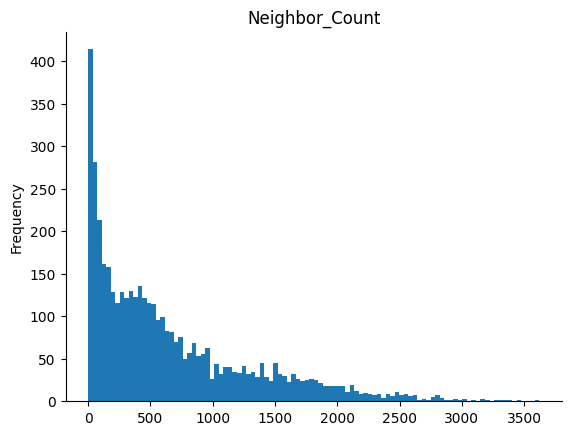

In [ ]:
from matplotlib import pyplot as plt
neigh_df['Neighbor_Count'].plot(kind='hist', bins=100, title='Neighbor_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
mean_neighbor_count = neigh_df['Neighbor_Count'].mean()
std_neighbor_count = neigh_df['Neighbor_Count'].std()
min_neighbor_count = neigh_df['Neighbor_Count'].min()
max_neighbor_count = neigh_df['Neighbor_Count'].max()


print(f"Mean Neighbor Count: {mean_neighbor_count}")
print(f"Standard Deviation of Neighbor Count: {std_neighbor_count}")
print(f"Minimum Neighbor Count: {min_neighbor_count}")
print(f"Maximum Neighbor Count: {max_neighbor_count}")


Mean Neighbor Count: 663.186958504332
Standard Deviation of Neighbor Count: 649.274018346211
Minimum Neighbor Count: 0
Maximum Neighbor Count: 3621


Many nodes only have a few neighbours. There are about 30 nodes that don't have neighbours.

In [ ]:
import pandas as pd
column_ones_count = pd.DataFrame((geo_data.x == 1).sum(dim=0), columns=['ones_count'])
column_ones_count

,ones_count
0,2863
1,794
2,13
3,118
4,2
...,...
2833,2
2834,4
2835,2
2836,2


In [ ]:
mean_neighbor_count = column_ones_count['ones_count'].mean()
std_neighbor_count = column_ones_count['ones_count'].std()
min_neighbor_count = column_ones_count['ones_count'].min()
max_neighbor_count = column_ones_count['ones_count'].max()


print(f"Mean 1 Count: {mean_neighbor_count}")
print(f"Standard Deviation of 1 Count: {std_neighbor_count}")
print(f"Minimum 1 Count: {min_neighbor_count}")
print(f"Maximum 1 Count: {max_neighbor_count}")

Mean 1 Count: 7.380549682875264
Standard Deviation of 1 Count: 59.70385440950332
Minimum 1 Count: 2
Maximum 1 Count: 2863


We also checked how many 1s are in each column. All the columns are one-hot encoded variables, so the data is very sparse

### Are ego networks all connected?

According to the Stanford SNAP site, all nodes and edges are inside both the Weakly Connected Components (WCC) and the Strongly Connected Components (SCC), meaning that the undirected graph composed of all egonets are connected into one graph. So the answer is yes in case of the "Facebook" dataset.

For the gplus dataset they are not. There are some nodes that have 0 neighbours.

## Evaluation criteria definition

This is an edge prediction problem, meaning it's actually a classification problem where we are going to utilize the accuracy metric for the predicted edges. We are also going to use standard binary classification metrics, such as ROC and AUC scores to see how correct our edge predictions are.

## Baseline model

*TODO*

## Model definition

*TODO* (incremental model refinement)

## Advanced evaluation

*TODO*

## Containerization

*TODO*

## ML-as-a-Service

Our solution is hosted online with the help of a local Gradio server (https://www.gradio.app/).

*TODO* (hosting the model for prediction)